In [1]:
!pip install pot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 7.6 MB/s eta 0:00:00


In [2]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import LinearSegmentedColormap
import math
import os
import seaborn as sns
import ot
import random
from random import randint
from pathlib import Path
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.stats import multivariate_normal

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Convolutional architecture

# Branch network
class Branch(nn.Module):
  def __init__(self):
    super(Branch, self).__init__()

    self.pool = nn.MaxPool3d(2, 2)

    self.conv1 = nn.Conv3d(1, 50, kernel_size=3, stride=1, padding=1, bias=True)
    self.conv2 = nn.Conv3d(50, 50, kernel_size=3, stride=2, padding=1, bias=True)
    self.conv3 = nn.Conv3d(50, 50, kernel_size=3, stride=2, padding=1, bias=True)
    self.conv4 = nn.Conv3d(50, 30, kernel_size=3, stride=2, padding=1, bias=True)


    # Batch normalization
    self.bn1 = nn.BatchNorm3d(50)
    self.bn2 = nn.BatchNorm3d(50)


  def forward(self, u):

    conv1_out = self.bn1(F.mish(self.conv1(u)))
    conv2_out = F.mish(self.conv2(conv1_out))
    conv3_out = self.bn2(F.mish(self.conv3(conv2_out)))
    output = self.conv4(conv3_out)
    output_flat = torch.flatten(output, start_dim=1, end_dim=4)
    return output_flat

In [16]:
t_w = 100 # trunk width

# Use Fourier feature embedding matrices
# Modify variance as necessary
#B = torch.from_numpy(np.random.normal(0,0.15,size=(100,4))).to(device).to(torch.float32)


# Trunk network
# Use enhanced architecture with Fourier feature embedding
class Trunk(nn.Module):
  def __init__(self):
    super(Trunk, self).__init__()

    self.hidden_U = nn.Linear(200,t_w, bias=True)
    self.hidden_V = nn.Linear(200,t_w, bias=True)
    self.hidden_H_1 = nn.Linear(200,t_w, bias=True); self.hidden_Z_1 = nn.Linear(t_w,t_w, bias=True)
    self.hidden_Z_2 = nn.Linear(t_w,t_w, bias=True); self.hidden_Z_3 = nn.Linear(t_w,t_w, bias=True)
    self.hidden_Z_4 = nn.Linear(t_w,240, bias=True)


  def forward(self, x,y,z,t):
    xyzt = torch.cat((x,y,z,t),1)
    Bz = torch.matmul(xyzt,torch.transpose(B,0,1))
    trig_B = torch.cat((torch.cos(2*torch.pi*Bz), torch.sin(2*torch.pi*Bz)),1)
    U = F.tanh(self.hidden_U(trig_B)); V = F.tanh(self.hidden_V(trig_B)); H_1 = F.tanh(self.hidden_H_1(trig_B));
    Z_1 = F.tanh(self.hidden_Z_1(H_1)); H_2 = (1 - Z_1)*U + Z_1*V
    Z_2 = F.tanh(self.hidden_Z_2(H_2)); H_3 = (1 - Z_2)*U + Z_2*V
    Z_3 = F.tanh(self.hidden_Z_3(H_3)); H_4 = (1 - Z_3)*U + Z_3*V
    Z_4 = self.hidden_Z_4(H_4)
    output = Z_4
    return output

In [ ]:
B_path = "B.pth"
torch.save(B, B_path)

In [17]:
B_path = "B.pth"
B = torch.load(B_path)

In [80]:
# Declare networks
cty_branch0 = Branch().to(device)
cty_branch1 = Branch().to(device)
cty_trunk = Trunk().to(device)

HJ_branch0 = Branch().to(device)
HJ_branch1 = Branch().to(device)
HJ_trunk = Trunk().to(device)

In [81]:
optimizer = optim.Adam([
    {'params': cty_branch0.parameters()},
    {'params': cty_branch1.parameters()},
    {'params': cty_trunk.parameters()},
    {'params': HJ_branch0.parameters()},
    {'params': HJ_branch1.parameters()},
    {'params': HJ_trunk.parameters()},
], lr=2e-4)

In [19]:
# Load in pre-trained networks

File = "Cty_branch0.pth"
cty_branch0.load_state_dict(torch.load(File))

File = "Cty_branch1.pth"
cty_branch1.load_state_dict(torch.load(File))

File = "Cty_trunk.pth"
cty_trunk.load_state_dict(torch.load(File))

File = "HJ_branch0.pth"
HJ_branch0.load_state_dict(torch.load(File))

File = "HJ_branch1.pth"
HJ_branch1.load_state_dict(torch.load(File))

File = "HJ_trunk.pth"
HJ_trunk.load_state_dict(torch.load(File))

<All keys matched successfully>

In [22]:
n = 15 # mesh size in one dimension
N = 1000 # number of Gaussians
N_p = 15000 # number of pairings
x_min = 0
x_max = 4
K = 5  # number of Gaussians in each mixtures
c = 1/K

t0 = torch.zeros(size=(n**3,1)).to(device)
t1 = 1*torch.ones(size=(n**3,1)).to(device)

x = np.linspace(x_min, x_max, n)
y = np.linspace(x_min, x_max, n)
z = np.linspace(x_min, x_max, n)
X, Y, Z = np.meshgrid(x, y, z)

X_vec = Variable(torch.from_numpy(X), requires_grad=True).to(device).type(torch.float32)
Y_vec = Variable(torch.from_numpy(Y), requires_grad=True).to(device).type(torch.float32)
Z_vec = Variable(torch.from_numpy(Z), requires_grad=True).to(device).type(torch.float32)

X_vec = torch.unsqueeze(X_vec.flatten(start_dim=0),1)
Y_vec = torch.unsqueeze(Y_vec.flatten(start_dim=0),1)
Z_vec = torch.unsqueeze(Z_vec.flatten(start_dim=0),1)

Omega_1dim = torch.unsqueeze(Variable(torch.from_numpy(x.flatten()), requires_grad=True),1).to(device).type(torch.float32)
Omega = np.concatenate([X[:,:,:,None], Y[:,:,:,None], Z[:,:,:,None]], axis=-1)

In [23]:
# Sample Gaussians
Gaussian_sample = np.zeros(shape=(N,n,n,n))

for m in range(N):

  means = np.random.uniform(low=0.8, high=x_max-0.8, size=(3))
  variances = np.random.uniform(low=0.275, high=0.3, size=(3))
  Sigma = np.random.uniform(low=-0.1, high=0.1, size=(3,3))
  Sigma[0,0] = variances[0]
  Sigma[1,1] = variances[1]
  Sigma[2,2] = variances[2]

  Gaussian_sample[m,:,:,:] = multivariate_normal.pdf(Omega, mean=means[:], cov=Sigma[:,:])

In [24]:
# Construct training data by sampling Gaussians

u0 = np.zeros(shape=(N_p,1,n,n,n))
u1 = np.zeros(shape=(N_p,1,n,n,n))

for i in range(N_p):

  for j in range(K):
    u0[i,0,:,:,:] = u0[i,0,:,:,:] + c * Gaussian_sample[np.random.randint(0,N,1),:,:,:]
    u1[i,0,:,:,:] = u1[i,0,:,:,:] + c * Gaussian_sample[np.random.randint(0,N,1),:,:,:]

  u0[i,0,:,:,:] /=  ((x_max/n)**3) * np.sum(u0[i,0,:,:,:])
  u1[i,0,:,:,:] /=  ((x_max/n)**3) * np.sum(u1[i,0,:,:,:])


In [82]:
# Save data to device

u0 = torch.from_numpy(u0).to(device).type(torch.float32)
u1 = torch.from_numpy(u1).to(device).type(torch.float32)

In [83]:
# Flatten input

u0_flat = torch.zeros(size=(N_p,n**3)).to(device).type(torch.float32)
u1_flat = torch.zeros(size=(N_p,n**3)).to(device).type(torch.float32)
for i in range(N_p):
  u0_flat[i,:] = u0[i,:,:,:,:].flatten(start_dim=1)
  u1_flat[i,:] = u1[i,:,:,:,:].flatten(start_dim=1)


In [ ]:
# Save training data

File = "u0.pth"
torch.save(u0, File)

File = "u1.pth"
torch.save(u1, File)

In [ ]:
# Load in training data

File = "u0.pth"
u0 = torch.load(File)

File = "u1.pth"
u1 = torch.load(File)

In [84]:
# Define physics-informed traiining loss

def physics_informed_loss(x, y, z, t, u0, u1, cty_branch0, cty_branch1, cty_trunk, HJ_branch0, HJ_branch1, HJ_trunk):

  # Continuity equation
  cty_branch0_output = cty_branch0(u0)
  cty_branch1_output = cty_branch1(u1)
  cty_trunk_output = cty_trunk(x, y, z, t)

  # Formulate continuity evaluations and derivatives
  cty = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output, dim=1)
  cty_x = torch.autograd.grad(cty.sum(), x, create_graph=True)[0]
  cty_y = torch.autograd.grad(cty.sum(), y, create_graph=True)[0]
  cty_z = torch.autograd.grad(cty.sum(), z, create_graph=True)[0]
  cty_t = torch.autograd.grad(cty.sum(), t, create_graph=True)[0]
  cty = torch.unsqueeze(cty,1)


  # Hamilton-Jacobi (HJ) equation
  HJ_branch0_output = HJ_branch0(u0)
  HJ_branch1_output = HJ_branch1(u1)
  HJ_trunk_output = HJ_trunk(x, y, z, t)

  # Formulate HJ evaluations and derivatives
  HJ = torch.sum( (HJ_branch0_output * HJ_branch1_output) * HJ_trunk_output, dim=1)
  HJ_x = torch.autograd.grad(HJ.sum(), x, create_graph=True)[0]
  HJ_xx = torch.autograd.grad(HJ_x.sum(), x, create_graph=True)[0]
  HJ_y = torch.autograd.grad(HJ.sum(), y, create_graph=True)[0]
  HJ_yy = torch.autograd.grad(HJ_y.sum(), y, create_graph=True)[0]
  HJ_z = torch.autograd.grad(HJ.sum(), z, create_graph=True)[0]
  HJ_zz = torch.autograd.grad(HJ_z.sum(), z, create_graph=True)[0]
  HJ_t = torch.autograd.grad(HJ.sum(), t, create_graph=True)[0]
  HJ = torch.unsqueeze(HJ,1)

  # Formulate loss terms
  cty_loss = (cty_t   +   cty_x*HJ_x + cty*HJ_xx   +   cty_y*HJ_y + cty*HJ_yy   +   cty_z*HJ_z + cty*HJ_zz )**2
  HJ_loss = 0.5*(HJ_t + (1/2)*(HJ_x**2 + HJ_y**2 + HJ_z**2))**2

  return(cty_loss + HJ_loss)

In [ ]:
# Training algorithm

num_iter = 1000000  # training iterations
batch_size = 300  # batch size

# Declare zero and one vector times
t0 = torch.zeros(size=(batch_size,1)).to(device)
t1 = 1*torch.ones(size=(batch_size,1)).to(device)


for i in range(num_iter):

  I = np.random.randint(0,N_p,batch_size)
  J = np.random.randint(0,n**3,batch_size)

  # Randomly sample domain (collocation procedure)
  x_unif = Variable(torch.from_numpy(np.random.uniform(0,x_max,size=(batch_size,1))).float(), requires_grad=True).to(device)
  y_unif = Variable(torch.from_numpy(np.random.uniform(0,x_max,size=(batch_size,1))).float(), requires_grad=True).to(device)
  z_unif = Variable(torch.from_numpy(np.random.uniform(0,x_max,size=(batch_size,1))).float(), requires_grad=True).to(device)
  t_unif = Variable(torch.from_numpy(np.random.uniform(0,1,size=(batch_size,1))).float(), requires_grad=True).to(device)

  # Evaluate continuity equations
  cty_branch0_output = cty_branch0(u0[I,:,:,:,:])
  cty_branch1_output = cty_branch1(u1[I,:,:,:,:])
  cty_trunk_output_0 = cty_trunk(X_vec[J], Y_vec[J], Z_vec[J], t0)
  cty_trunk_output_1 = cty_trunk(X_vec[J], Y_vec[J], Z_vec[J], t1)

  # Formulate enhanced deep operator networks with an inner product-like multiplication
  inner_prod_0 = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output_0, dim=1)
  inner_prod_1 = torch.sum( (cty_branch0_output * cty_branch1_output) * cty_trunk_output_1, dim=1)

  # Boundary loss at t=0, t=1
  diff_0 = inner_prod_0 - u0_flat[I,J]
  diff_1 = inner_prod_1 - u1_flat[I,J]
  boundary_loss_0 = (1/torch.numel(diff_0)) * torch.norm(diff_0)**2
  boundary_loss_1 = (1/torch.numel(diff_1)) * torch.norm(diff_1)**2

  # Evaluate physics loss
  physics_term = physics_informed_loss(x_unif, y_unif, z_unif, t_unif, u0[I,:,:,:,:], u1[I,:,:,:,:], cty_branch0, cty_branch1, cty_trunk, HJ_branch0, HJ_branch1, HJ_trunk)
  physics_loss = (1/torch.numel(physics_term)) * torch.sum(physics_term)

  # Formulate total loss
  loss = 20*boundary_loss_0  + 20*boundary_loss_1  +  0.5*physics_loss


  optimizer.zero_grad()

  loss.backward()

  torch.nn.utils.clip_grad_value_(cty_branch0.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(cty_branch1.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(cty_trunk.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(HJ_branch0.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(HJ_branch1.parameters(), 1.)
  torch.nn.utils.clip_grad_value_(HJ_trunk.parameters(), 1.)

  optimizer.step()

  if i % 20 == 0:
    print("Training loss:", '{:.4e}'.format(loss.data), "PINN loss:", '{:.4e}'.format(physics_loss))

In [ ]:
#### Save the models to current directory

File = "Cty_branch0.pth"
torch.save(cty_branch0.state_dict(), File)

File = "Cty_branch1.pth"
torch.save(cty_branch1.state_dict(), File)

File = "Cty_trunk.pth"
torch.save(cty_trunk.state_dict(), File)

File = "HJ_branch0.pth"
torch.save(HJ_branch0.state_dict(), File)

File = "HJ_branch1.pth"
torch.save(HJ_branch1.state_dict(), File)

File = "HJ_trunk.pth"
torch.save(HJ_trunk.state_dict(), File)

# Save Fourier feature input matrix as well
B_path = "B.pth"
torch.save(B, B_path)

In [71]:
# Test results


# Collect sample test data

u0_test = np.zeros(shape=(1,1,n,n,n))
u1_test = np.zeros(shape=(1,1,n,n,n))

for j in range(K):
  u0_test[0,0,:,:,:] = u0_test[0,0,:,:,:] + c * Gaussian_sample[np.random.randint(0,N,1),:,:,:]
  u1_test[0,0,:,:,:] = u1_test[0,0,:,:,:] + c * Gaussian_sample[np.random.randint(0,N,1),:,:,:]

u0_test[0,0,:,:,:] /=  ((x_max/n)**3) * np.sum(u0_test[0,0,:,:,:])
u1_test[0,0,:,:,:] /=  ((x_max/n)**3) * np.sum(u1_test[0,0,:,:,:])

u0_test[1:n**3-1,:,:,:,:] = u0_test[0,:,:,:,:]
u1_test[1:n**3-1,:,:,:,:] = u1_test[0,:,:,:,:]

u0_test = torch.from_numpy(u0_test).to(device).type(torch.float32)
u1_test = torch.from_numpy(u1_test).to(device).type(torch.float32)

In [72]:
# Evaluate test at a single time
t = 0.0*torch.ones(size=(n**3,1)).to(device)  # Modify this for a particular time

cty_branch0_output = cty_branch0(u0_test[:,:,:,:,:])
cty_branch1_output = cty_branch1(u1_test[:,:,:,:,:])

cty_branch0_repeat = cty_branch0_output.repeat((n**3,1))
cty_branch1_repeat = cty_branch1_output.repeat((n**3,1))
cty_trunk_output = cty_trunk(X_vec, Y_vec, Z_vec, t)

inner_prod = torch.sum( (cty_branch0_repeat * cty_branch1_repeat) * cty_trunk_output, dim=1)
inner_prod_reshape = torch.reshape(inner_prod[:], (1,1,15,15,15))

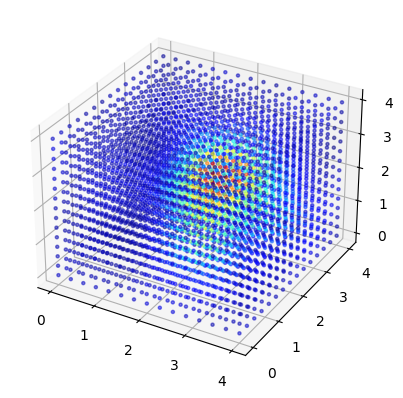

In [73]:
fig = plt.figure()
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(X, Y, Z, c=inner_prod_reshape.cpu().detach().numpy(), alpha=0.5, marker='.', cmap='jet')
plt.show()

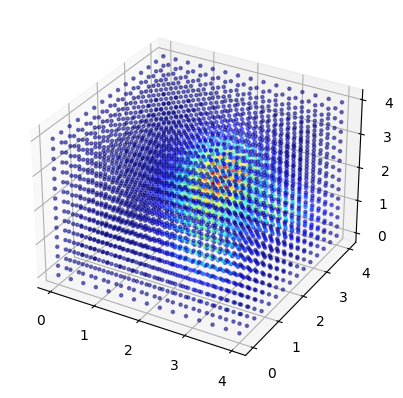

In [74]:
fig = plt.figure()
ax = plt.axes(projection="3d")

# Creating plot
ax.scatter3D(X, Y, Z, c=u0_test.cpu().detach().numpy(), alpha=0.5, marker='.', cmap='jet')
plt.show()

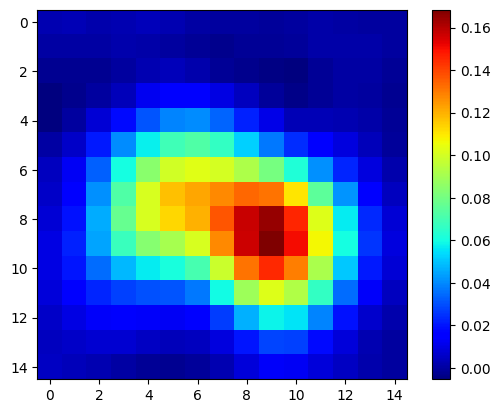

In [75]:
# Plot cross-section
fig, ax = plt.subplots()
shw = ax.imshow(inner_prod_reshape[0,0,7,:,:].cpu().detach().numpy(), cmap='jet')
bar = plt.colorbar(shw)
plt.show()

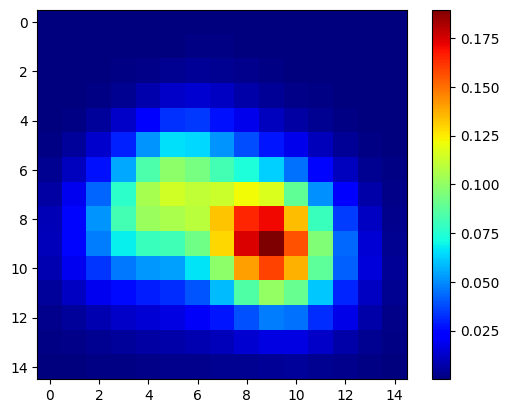

In [76]:
fig, ax = plt.subplots()
shw = ax.imshow(u0_test[0,0,7,:,:].cpu().detach().numpy(), cmap='jet')
bar = plt.colorbar(shw)
plt.show()

In [77]:
# Evaluate test results at t=0,0.25,0.5,0.75,1

u_test_grid = np.zeros(shape=(5,15,15,15))


for i in range(5):
  t = (i/4)*torch.ones(size=(n**3,1)).to(device)

  cty_branch0_output = cty_branch0(u0_test[:,:,:,:,:])
  cty_branch1_output = cty_branch1(u1_test[:,:,:,:,:])

  cty_branch0_repeat = cty_branch0_output.repeat((n**3,1))
  cty_branch1_repeat = cty_branch1_output.repeat((n**3,1))
  cty_trunk_output = cty_trunk(X_vec, Y_vec, Z_vec, t)

  inner_prod = torch.sum( (cty_branch0_repeat * cty_branch1_repeat) * cty_trunk_output, dim=1)
  inner_prod_reshape = torch.reshape(inner_prod[:], (1,1,15,15,15))

  u_test_grid[i,:,:,:] = inner_prod_reshape[0,0,:,:,:].cpu().detach().numpy()

In [78]:
def figure_grid(u, u0, u1):
    # Plot the geodesics at the five times
    fig = plt.figure(figsize=(22, 9))
    cmap = 'jet'

    for i in range(7):
        ax = fig.add_subplot(1, 7, i+1, projection='3d')
        if i == 0:
            sc = ax.scatter3D(X, Y, Z, c=u0, alpha=0.5, marker='.', cmap=cmap, s=6)
        elif i == 6:
            sc = ax.scatter3D(X, Y, Z, c=u1, alpha=0.5, marker='.', cmap=cmap, s=6)
        else:
            sc = ax.scatter3D(X, Y, Z, c=u[i-1,:,:,:], alpha=0.5, marker='.', cmap=cmap, s=6)
        ax.set(xticklabels=[]); ax.set(yticklabels=[]); ax.set(zticklabels=[]); ax.tick_params(left=False, bottom=False)

    plt.savefig('Pred_geodesic.png', dpi=500)
    plt.xticks([])
    plt.yticks([])
    plt.show()

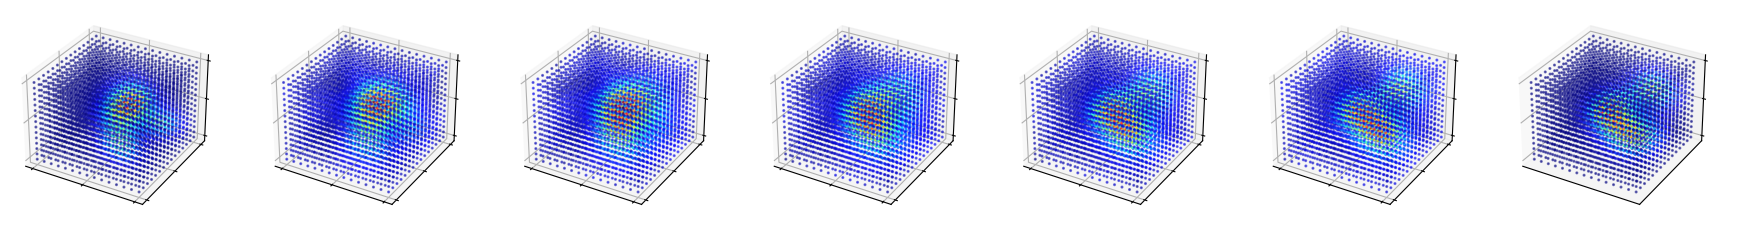

In [79]:
figure_grid(u_test_grid, u0_test.cpu().detach().numpy(), u1_test.cpu().detach().numpy())